<a href="https://colab.research.google.com/github/YashRaval201/IIIT-Allahabad-Projects/blob/main/Handwritten_Digit_Generation_using_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/200
938/938 [==============================] - 10s 7ms/step - d_loss: 0.4065 - g_loss: 1.0988
Epoch 2/200
938/938 [==============================] - 8s 8ms/step - d_loss: 0.4954 - g_loss: 1.2281
Epoch 3/200
938/938 [==============================] - 8s 8ms/step - d_loss: 0.5880 - g_loss: 0.9921
Epoch 4/200
938/938 [==============================] - 7s 7ms/step - d_loss: 0.6000 - g_loss: 0.9421
Epoch 5/200
938/938 [==============================] - 9s 9ms/step - d_loss: 0.6182 - g_loss: 0.9105
Epoch 6/200
938/938 [==============================] - 8s 8ms/step - d_loss: 0.6134 - g_loss: 0.9026
Epoch 7/200
938/938 [==============================] - 7s 7ms/step - d_loss: 0.5954 - g_loss: 0.9361
Epoch 8/200
938/938 [==============================] - 8s 8ms/step - d_loss: 0.5725 - g_loss: 0.9817
Epoch 9/200
938/938 [==============================] - 7s 7ms/step - d_loss: 0.5520 - g_loss: 1.0548
Epoch 10/200
938/938 [==============================] - 9s 9ms/step - d_loss: 0.5468 - g_l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


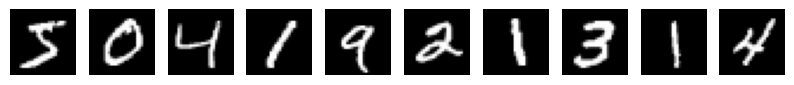

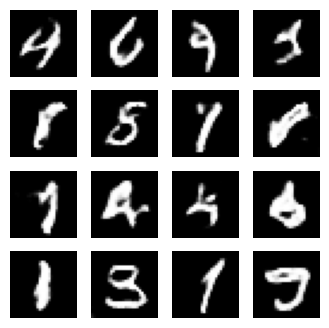

In [ ]:
import os
import tensorflow as tf
from keras import models,layers
import numpy as np
import matplotlib.pyplot as plt

def plot_images(generated_images, n_rows=1, n_cols=10):
    f, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    ax = ax.flatten()
    for i in range(n_rows*n_cols):
        ax[i].imshow(generated_images[i, :, :], cmap='gray')
        ax[i].axis('off')
    return f, ax

class GenerateSamplesCallback(tf.keras.callbacks.Callback):
    def __init__(self, generator, noise):
        self.generator = generator
        self.noise = noise

    def on_epoch_end(self, epoch, logs=None):
        if not os.path.exists("generated_images"):
            os.mkdir("generated_images")
        generated_images = self.generator(self.noise, training=False)
        generated_images = generated_images.numpy()
        generated_images = generated_images*127.5 + 127.5
        generated_images = generated_images.reshape((10, 28, 28))
        # plot images using matplotlib
        plot_images(generated_images)
        plt.savefig(os.path.join("generated_images", f"generated_images_{epoch}.png"))
        # close the plot to free up memory
        plt.close()

def build_discriminator():
    model = models.Sequential()#allows us to create linear stack of layers to create a neural network
    model.add(layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))#adds a convolutional layer to the model with 16 filters, a 5x5 kernel size, 2x2 stride, 'same' padding, input shape based on the shape of 28*28*1
    model.add(layers.LeakyReLU())#add a leaky relu activation function to the model
    model.add(layers.Dropout(rate=0.3))#add a dropout layer with a rate of 0.3
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))##adds a convolutional layer to the model with 32 filters, a 5x5 kernel size, 2x2 stride, 'same' padding
    model.add(layers.LeakyReLU())#add a leaky relu activation function to the model
    model.add(layers.Dropout(0.3))#add a dropout layer with a rate of 0.3
    model.add(layers.Flatten())#flattens the output of the convolutional layers to a 1D tensor to be passed to the fully connected layers
    model.add(layers.Dense(units=1))#adds a fully connected layer to the model with 1 unit
    return model #returns model

def build_generator():
    # output size = (input size - filter size + (2*padding)) / 2 + 1
    model = models.Sequential()#allows us to create linear stack of layers to create a neural network
    model.add(layers.Dense(units=7*7*8, use_bias=False, input_shape=(100,)))#adds a fully connected layer to the model with 7*7*8 units
    model.add(layers.BatchNormalization())#add a batch normalization layer to normalize the activations of the previous layer
    model.add(layers.LeakyReLU())#add a leaky relu activation function to the model
    model.add(layers.Reshape((7, 7, 8)))#shape the output of the previous layer to (7, 7, 8)
    model.add(layers.Conv2DTranspose(8, (5, 5), strides=(1, 1), padding='same', use_bias=False))#adds a transposed convolutional layer to the model with 8 filters, a 5x5 kernel size, 1x1 stride, 'same' padding and no bias
    model.add(layers.BatchNormalization())#add a batch normalization layer to normalize the activations of the previous layer
    model.add(layers.LeakyReLU())#add a leaky relu activation function to the model
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))#adds a transposed convolutional layer to the model with 16 filters, a 5x5 kernel size, 2x2 stride, 'same' padding and no bias
    model.add(layers.BatchNormalization())#add a batch normalization layer to normalize the activations of the previous layer
    model.add(layers.LeakyReLU())#add a leaky relu activation function to the model
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))#adds a transposed convolutional layer to the model with 1 filter, a 5x5 kernel size, 2x2 stride, 'same' padding, no bias and Tanh as activation function
    return model#return model

class DCGAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.dimension = self.generator.input_shape[1]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        batch_size = tf.shape(data)[0] #batch size is nothing but number of rows of the data
        noise = tf.random.uniform([batch_size, self.dimension]) #creating noise inorder to generate fake images useing it
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape: #useing gradient tape for generator and discriminator
            fake_input = self.generator(noise, training=True)#created fake images by passing nosise in generator function
            real_output = self.discriminator(data, training=True)#created real images output using descriminator function
            fake_output = self.discriminator(fake_input, training=True)#created fake images output using descriminator function
            g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)#found the loss between fake image output and the output to give generator loss
            d_loss = self.loss_fn(tf.concat([tf.ones_like(real_output), tf.zeros_like(fake_output)], axis=0), tf.concat([real_output, fake_output], axis=0))#found the loss between fake and real image outputs and their respective outputs  to give generator loss to give discriminator loss
        d_grad = d_tape.gradient(d_loss, self.discriminator.trainable_variables) #calculates gradient for discriminator
        g_grad = g_tape.gradient(g_loss, self.generator.trainable_variables)#calculates gradient for generator
        self.d_optimizer.apply_gradients(zip(d_grad, self.discriminator.trainable_variables))#applies gradients to update discriminator weights
        self.g_optimizer.apply_gradients(zip(g_grad, self.generator.trainable_variables))#applies gradients to update generator weights
        return {'d_loss':d_loss, 'g_loss':g_loss}#return dictionary of discriminator loss and generator loss

def train_dcgan_mnist():
    tf.keras.utils.set_random_seed(5368)
    # load mnist
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # the images are in the range [0, 255], we need to rescale them to [-1, 1]
    x_train = (x_train - 127.5) / 127.5
    x_train = x_train[..., tf.newaxis].astype(np.float32)

    # plot 10 random images
    example_images = x_train[:10]*127.5 + 127.5
    plot_images(example_images)

    plt.savefig("real_images.png")


    # build the discriminator and the generator
    discriminator = build_discriminator()
    generator = build_generator()


    # build the DCGAN
    dcgan = DCGAN(discriminator=discriminator, generator=generator)

    # compile the DCGAN
    dcgan.compile(d_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  g_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True))

    callbacks = [GenerateSamplesCallback(generator, tf.random.uniform([10, 100]))]
    # train the DCGAN
    dcgan.fit(x_train, epochs=200, batch_size=64, callbacks=callbacks, shuffle=True)

    # generate images
    noise = tf.random.uniform([16, 100])
    generated_images = generator(noise, training=False)
    plot_images(generated_images*127.5 + 127.5, 4, 4)
    plt.savefig("generated_images.png")

    generator.save('generator.h5')


if __name__ == "__main__":
    train_dcgan_mnist()